# IEEE Fraud Detection Kaggle Competition

features from: https://www.kaggle.com/roydatascience/light-gbm-with-complete-eda/notebook#Feature-Engineering

In [15]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import lightgbm as lgb
from sklearn.metrics import roc_auc_score

/Users/cchadha2/anaconda3/envs/eda/lib/python3.7/site-packages/lightgbm/__init__.py:46: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_9.4.1) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


In [16]:
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)

num_folds = 5
SEED = 5000

In [17]:
import random, os
def seed_everything(seed=SEED):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    
seed_everything()

In [18]:
sampled_train_original = pd.read_csv('../../output/sampled_train_reduced_mem.csv')
train_original = pd.read_csv('../../output/train_reduced_mem.csv')
test_original = pd.read_csv('../../output/test_reduced_mem.csv')

In [55]:
params = {
                'objective':'binary',
                'boosting_type':'gbdt',
                'metric':'auc',
                'n_jobs':-1,
                'learning_rate':0.064,
                'num_leaves': 2**8,
                'max_depth':-1,
                'tree_learner':'serial',
                'colsample_bytree': 0.85,
                'subsample_freq':1,
                'subsample':0.85,
                'max_bin':255,
                'verbose':-1,
                'seed': SEED,
                'reg_alpha':0.3,
                'reg_lamdba':0.243
            } 
# Uses a lower learning rate - default is 0.1. This is not changed in my notebooks, try again with this change?
params['learning_rate'] = 0.005
params['n_estimators'] = 3000
# params['n_estimators'] = 550
params['early_stopping_rounds'] = 100    

In [20]:
sampled_train_original.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15,M1,M2,M3,M4,M5,M6,M7,M8,M9,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,V41,V42,V43,V44,V45,V46,V47,V48,V49,V50,V51,V52,V53,V54,V55,V56,V57,V58,V59,V60,V61,V62,V63,V64,V65,V66,V67,V68,V69,V70,V71,V72,V73,V74,V75,V76,V77,V78,V79,V80,V81,V82,V83,V84,V85,V86,V87,V88,V89,V90,V91,V92,V93,V94,V95,V96,V97,V98,V99,V100,V101,V102,V103,V104,V105,V106,V107,V108,V109,V110,V111,V112,V113,V114,V115,V116,V117,V118,V119,V120,V121,V122,V123,V124,V125,V126,V127,V128,V129,V130,V131,V132,V133,V134,V135,V136,V137,V138,V139,V140,V141,V142,V143,V144,V145,V146,V147,V148,V149,V150,V151,V152,V153,V154,V155,V156,V157,V158,V159,V160,V161,V162,V163,V164,V165,V166,V167,V168,V169,V170,V171,V172,V173,V174,V175,V176,V177,V178,V179,V180,V181,V182,V183,V184,V185,V186,V187,V188,V189,V190,V191,V192,V193,V194,V195,V196,V197,V198,V199,V200,V201,V202,V203,V204,V205,V206,V207,V208,V209,V210,V211,V212,V213,V214,V215,V216,V217,V218,V219,V220,V221,V222,V223,V224,V225,V226,V227,V228,V229,V230,V231,V232,V233,V234,V235,V236,V237,V238,V239,V240,V241,V242,V243,V244,V245,V246,V247,V248,V249,V250,V251,V252,V253,V254,V255,V256,V257,V258,V259,V260,V261,V262,V263,V264,V265,V266,V267,V268,V269,V270,V271,V272,V273,V274,V275,V276,V277,V278,V279,V280,V281,V282,V283,V284,V285,V286,V287,V288,V289,V290,V291,V292,V293,V294,V295,V296,V297,V298,V299,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,id_11,id_12,id_13,id_14,id_15,id_16,id_17,id_18,id_19,id_20,id_21,id_22,id_23,id_24,id_25,id_26,id_27,id_28,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo,TransactionWeek
0,2996780,0,302413,25.98,C,4461,375.0,185.0,mastercard,224.0,debit,NaN,NaN,NaN,NaN,gmail.com,gmail.com,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,0.0,NaN,NaN,NaN,0.0,NaN,0.0,0.0,0.0,0.0,NaN,NaN,NaN,M2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0000,0.0000,0.0000,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0000,0.0000,0.0000,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0000,0.0000,0.0000,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,334122.0,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,100.0,NotFound,NaN,NaN,New,NotFound,225.0,NaN,266.0,325.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NotFound,NaN,chrome 62.0 for android,NaN,NaN,NaN,F,F,T,T,mobile,F3213 Build/36.1.

In [21]:
n_days_in_week_21 = 18509

In [22]:
"""
This module provides a class to split time-series data for back-testing and evaluation.
The aim was to extend the current sklearn implementation and extend it's uses.

Might be useful for some ;)
"""

import logging
from typing import Optional

import numpy as np
from sklearn.model_selection._split import _BaseKFold
from sklearn.utils import indexable
from sklearn.utils.validation import _num_samples

LOGGER = logging.getLogger(__name__)


class TimeSeriesSplit(_BaseKFold):  # pylint: disable=abstract-method
    """Time Series cross-validator

    Provides train/test indices to split time series data samples that are observed at fixed time intervals,
    in train/test sets. In each split, test indices must be higher than before, and thus shuffling in cross validator is
    inappropriate.

    This cross_validation object is a variation of :class:`TimeSeriesSplit` from the popular scikit-learn package.
    It extends its base functionality to allow for expanding windows, and rolling windows with configurable train and
    test sizes and delays between each. i.e. train on weeks 1-8, skip week 9, predict week 10-11.

    In this implementation we specifically force the test size to be equal across all splits.

    Expanding Window:

            Idx / Time  0..............................................n
            1           |  train  | delay |  test  |                   |
            2           |       train     | delay  |  test  |          |
            ...         |                                              |
            last        |            train            | delay |  test  |

    Rolling Windows:
            Idx / Time  0..............................................n
            1           | train   | delay |  test  |                   |
            2           | step |  train  | delay |  test  |            |
            ...         |                                              |
            last        | step | ... | step |  train  | delay |  test  |

    Parameters:
        n_splits : int, default=5
            Number of splits. Must be at least 4.

        train_size : int, optional
            Size for a single training set.

        test_size : int, optional, must be positive
            Size of a single testing set

        delay : int, default=0, must be positive
            Number of index shifts to make between train and test sets
            e.g,
            delay=0
                TRAIN: [0 1 2 3] TEST: [4]
            delay=1
                TRAIN: [0 1 2 3] TEST: [5]
            delay=2
                TRAIN: [0 1 2 3] TEST: [6]

        force_step_size : int, optional
            Ignore split logic and force the training data to shift by the step size forward for n_splits
            e.g
            TRAIN: [ 0  1  2  3] TEST: [4]
            TRAIN: [ 0  1  2  3  4] TEST: [5]
            TRAIN: [ 0  1  2  3  4  5] TEST: [6]
            TRAIN: [ 0  1  2  3  4  5  6] TEST: [7]

    Examples
    --------
    >>> X = np.array([[1, 2], [3, 4], [1, 2], [3, 4], [1, 2], [3, 4]])
    >>> y = np.array([1, 2, 3, 4, 5, 6])
    >>> tscv = TimeSeriesSplit(n_splits=5)
    >>> print(tscv)  # doctest: +NORMALIZE_WHITESPACE
    TimeSeriesSplit(train_size=None, n_splits=5)
    >>> for train_index, test_index in tscv.split(X):
    ...    print('TRAIN:', train_index, 'TEST:', test_index)
    ...    X_train, X_test = X[train_index], X[test_index]
    ...    y_train, y_test = y[train_index], y[test_index]
    TRAIN: [0] TEST: [1]
    TRAIN: [0 1] TEST: [2]
    TRAIN: [0 1 2] TEST: [3]
    TRAIN: [0 1 2 3] TEST: [4]
    TRAIN: [0 1 2 3 4] TEST: [5]
    """

    def __init__(self,
                 n_splits: Optional[int] = 5,
                 train_size: Optional[int] = None,
                 test_size: Optional[int] = None,
                 delay: int = 0,
                 force_step_size: Optional[int] = None):

        if n_splits and n_splits < 5:
            raise ValueError(f'Cannot have n_splits less than 5 (n_splits={n_splits})')
        super().__init__(n_splits, shuffle=False, random_state=None)

        self.train_size = train_size

        if test_size and test_size < 0:
            raise ValueError(f'Cannot have negative values of test_size (test_size={test_size})')
        self.test_size = test_size

        if delay < 0:
            raise ValueError(f'Cannot have negative values of delay (delay={delay})')
        self.delay = delay

        if force_step_size and force_step_size < 1:
            raise ValueError(f'Cannot have zero or negative values of force_step_size '
                             f'(force_step_size={force_step_size}).')

        self.force_step_size = force_step_size

    def split(self, X, y=None, groups=None):
        """Generate indices to split data into training and test set.

        Parameters:
            X : array-like, shape (n_samples, n_features)
                Training data, where n_samples is the number of samples  and n_features is the number of features.

            y : array-like, shape (n_samples,)
                Always ignored, exists for compatibility.

            groups : array-like, with shape (n_samples,), optional
                Always ignored, exists for compatibility.

        Yields:
            train : ndarray
                The training set indices for that split.

            test : ndarray
                The testing set indices for that split.
        """
        X, y, groups = indexable(X, y, groups)  # pylint: disable=unbalanced-tuple-unpacking
        n_samples = _num_samples(X)
        n_splits = self.n_splits
        n_folds = n_splits + 1
        delay = self.delay

        if n_folds > n_samples:
            raise ValueError(f'Cannot have number of folds={n_folds} greater than the number of samples: {n_samples}.')

        indices = np.arange(n_samples)
        split_size = n_samples // n_folds

        train_size = self.train_size or split_size * self.n_splits
        test_size = self.test_size or n_samples // n_folds
        full_test = test_size + delay

        if full_test + n_splits > n_samples:
            raise ValueError(f'test_size\\({test_size}\\) + delay\\({delay}\\) = {test_size + delay} + '
                             f'n_splits={n_splits} \n'
                             f' greater than the number of samples: {n_samples}. Cannot create fold logic.')

        # Generate logic for splits.
        # Overwrite fold test_starts ranges if force_step_size is specified.
        if self.force_step_size:
            step_size = self.force_step_size
            final_fold_start = n_samples - (train_size + full_test)
            range_start = (final_fold_start % step_size) + train_size

            test_starts = range(range_start, n_samples, step_size)

        else:
            if not self.train_size:
                step_size = split_size
                range_start = (split_size - full_test) + split_size + (n_samples % n_folds)
            else:
                step_size = (n_samples - (train_size + full_test)) // n_folds
                final_fold_start = n_samples - (train_size + full_test)
                range_start = (final_fold_start - (step_size * (n_splits - 1))) + train_size

            test_starts = range(range_start, n_samples, step_size)

        # Generate data splits.
        for test_start in test_starts:
            idx_start = test_start - train_size if self.train_size is not None else 0
            # Ensure we always return a test set of the same size
            if indices[test_start:test_start + full_test].size < full_test:
                continue
            yield (indices[idx_start:test_start],
                   indices[test_start + delay:test_start + full_test])

# Feature Engineering

In [23]:
sampled_train = sampled_train_original.copy()
train = train_original.copy()
test = test_original.copy()

In [24]:
sampled_train.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15,M1,M2,M3,M4,M5,M6,M7,M8,M9,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,V41,V42,V43,V44,V45,V46,V47,V48,V49,V50,V51,V52,V53,V54,V55,V56,V57,V58,V59,V60,V61,V62,V63,V64,V65,V66,V67,V68,V69,V70,V71,V72,V73,V74,V75,V76,V77,V78,V79,V80,V81,V82,V83,V84,V85,V86,V87,V88,V89,V90,V91,V92,V93,V94,V95,V96,V97,V98,V99,V100,V101,V102,V103,V104,V105,V106,V107,V108,V109,V110,V111,V112,V113,V114,V115,V116,V117,V118,V119,V120,V121,V122,V123,V124,V125,V126,V127,V128,V129,V130,V131,V132,V133,V134,V135,V136,V137,V138,V139,V140,V141,V142,V143,V144,V145,V146,V147,V148,V149,V150,V151,V152,V153,V154,V155,V156,V157,V158,V159,V160,V161,V162,V163,V164,V165,V166,V167,V168,V169,V170,V171,V172,V173,V174,V175,V176,V177,V178,V179,V180,V181,V182,V183,V184,V185,V186,V187,V188,V189,V190,V191,V192,V193,V194,V195,V196,V197,V198,V199,V200,V201,V202,V203,V204,V205,V206,V207,V208,V209,V210,V211,V212,V213,V214,V215,V216,V217,V218,V219,V220,V221,V222,V223,V224,V225,V226,V227,V228,V229,V230,V231,V232,V233,V234,V235,V236,V237,V238,V239,V240,V241,V242,V243,V244,V245,V246,V247,V248,V249,V250,V251,V252,V253,V254,V255,V256,V257,V258,V259,V260,V261,V262,V263,V264,V265,V266,V267,V268,V269,V270,V271,V272,V273,V274,V275,V276,V277,V278,V279,V280,V281,V282,V283,V284,V285,V286,V287,V288,V289,V290,V291,V292,V293,V294,V295,V296,V297,V298,V299,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,id_11,id_12,id_13,id_14,id_15,id_16,id_17,id_18,id_19,id_20,id_21,id_22,id_23,id_24,id_25,id_26,id_27,id_28,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo,TransactionWeek
0,2996780,0,302413,25.98,C,4461,375.0,185.0,mastercard,224.0,debit,NaN,NaN,NaN,NaN,gmail.com,gmail.com,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,0.0,NaN,NaN,NaN,0.0,NaN,0.0,0.0,0.0,0.0,NaN,NaN,NaN,M2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0000,0.0000,0.0000,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0000,0.0000,0.0000,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0000,0.0000,0.0000,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,334122.0,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,100.0,NotFound,NaN,NaN,New,NotFound,225.0,NaN,266.0,325.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NotFound,NaN,chrome 62.0 for android,NaN,NaN,NaN,F,F,T,T,mobile,F3213 Build/36.1.

In [25]:
valid_card = train['card1'].value_counts()
valid_card = valid_card[valid_card>10]
valid_card = list(valid_card.index)

sampled_train['card1'] = np.where(sampled_train['card1'].isin(valid_card), sampled_train['card1'], np.nan)
train['card1'] = np.where(train['card1'].isin(valid_card), train['card1'], np.nan)
test['card1'] = np.where(test['card1'].isin(valid_card), test['card1'], np.nan)

In [26]:
one_value_cols = [col for col in train.columns if train[col].nunique() <= 1]
one_value_cols_test = [col for col in test.columns if test[col].nunique() <= 1]

many_null_cols = [col for col in train.columns if train[col].isnull().sum() / train.shape[0] > 0.9]
many_null_cols_test = [col for col in test.columns if test[col].isnull().sum() / test.shape[0] > 0.9]

big_top_value_cols = [col for col in train.columns if train[col].value_counts(dropna=False, normalize=True).values[0] > 0.9]
big_top_value_cols_test = [col for col in test.columns if test[col].value_counts(dropna=False, normalize=True).values[0] > 0.9]

cols_to_drop = list(set(many_null_cols + many_null_cols_test + big_top_value_cols + big_top_value_cols_test + one_value_cols + one_value_cols_test))
cols_to_drop.remove('isFraud')
print('{} features are going to be dropped for being useless'.format(len(cols_to_drop)))

sampled_train = sampled_train.drop(cols_to_drop, axis=1)
train = train.drop(cols_to_drop, axis=1)
test = test.drop(cols_to_drop, axis=1)

82 features are going to be dropped for being useless


In [27]:
i_cols = ['card1','card2','card3','card5',
          'C1','C2','C4','C5','C6','C7','C8','C9','C10','C11','C12','C13','C14',
          'D1','D2','D3','D4','D5','D6','D8','D9',
          'addr1','addr2',
          'dist1',
          'P_emaildomain', 'R_emaildomain'
         ]

for col in i_cols:
    temp_df = pd.concat([train[[col]], test[[col]]])
    fq_encode = temp_df[col].value_counts().to_dict()   
    
    sampled_train[col+'_fq_enc'] = sampled_train[col].map(fq_encode)

In [28]:
for col in ['ProductCD','M4']:
    temp_dict = train.groupby([col])['isFraud'].agg(['mean']).reset_index().rename(
                                                        columns={'mean': col+'_target_mean'})
    temp_dict.index = temp_dict[col].values
    temp_dict = temp_dict[col+'_target_mean'].to_dict()
    
    sampled_train[col+'_target_mean'] = sampled_train[col].map(temp_dict)

In [29]:
from sklearn.preprocessing import LabelEncoder

for col in list(train):
    if train[col].dtype=='O':
        print(col)
        sampled_train[col] = sampled_train[col].fillna('unseen_before_label')
        train[col] = train[col].fillna('unseen_before_label')
        test[col]  = test[col].fillna('unseen_before_label')
        
        sampled_train[col] = sampled_train[col].astype(str)
        train[col] = train[col].astype(str)
        test[col] = test[col].astype(str)
        
        le = LabelEncoder()
        le.fit(list(train[col])+list(test[col]))
        sampled_train[col] = le.transform(sampled_train[col])

ProductCD
card4
card6
P_emaildomain
R_emaildomain
M1
M2
M3
M4
M5
M6
M7
M8
M9
id_12
id_15
id_16
id_28
id_29
id_30
id_31
id_33
id_34
id_35
id_36
id_37
id_38
DeviceType
DeviceInfo


In [30]:
valid_card = train['TransactionAmt'].value_counts()
valid_card = valid_card[valid_card>10]
valid_card = list(valid_card.index)

i_cols = ['card1','card2','card3','card5']

for col in i_cols:
    for agg_type in ['mean', 'std']:
        new_col_name = col+'_TransactionAmt_'+agg_type
        temp_df = pd.concat([train[[col, 'TransactionAmt']], test[[col,'TransactionAmt']]])
        temp_df = temp_df.groupby([col])['TransactionAmt'].agg([agg_type]).reset_index().rename(
                                                columns={agg_type: new_col_name})
        
        temp_df.index = list(temp_df[col])
        temp_df = temp_df[new_col_name].to_dict()   
        
        sampled_train[new_col_name] = sampled_train[col].map(temp_df)

In [31]:
def country_match(df):
    
    temp_df = df[['card3', 'addr2']]
    temp_df['country_match'] = np.nan
    temp_df['country_match'] = np.where((temp_df['card3'] == 150) & (temp_df['addr2'] == 87),
                                        1,
                                        temp_df['country_match'])
    
    temp_df['country_match'] = np.where((temp_df['card3'] == 150) & (temp_df['addr2'] != 87),
                                        1,
                                        temp_df['country_match'])
    
    temp_df['country_match'] = np.where((temp_df['card3'] != 150) & (temp_df['addr2'] == 87),
                                        1,
                                        temp_df['country_match'])

    temp_df['country_match'] = np.where((temp_df['card3'] == 185) & (temp_df['addr2'] == 60),
                                        1,
                                        temp_df['country_match'])
    
    temp_df['country_match'] = np.where((temp_df['card3'] == 185) & (temp_df['addr2'] != 60),
                                        0,
                                        temp_df['country_match'])
    
    temp_df['country_match'] = np.where((temp_df['card3'] != 185) & (temp_df['addr2'] == 60),
                                        0,
                                        temp_df['country_match'])

    temp_df['country_match'] = np.where((temp_df['card3'] == 144) & (temp_df['addr2'] == 96),
                                        1,
                                        temp_df['country_match'])
    
    temp_df['country_match'] = np.where((temp_df['card3'] == 144) & (temp_df['addr2'] != 96),
                                        0,
                                        temp_df['country_match'])
    
    temp_df['country_match'] = np.where((temp_df['card3'] != 144) & (temp_df['addr2'] == 96),
                                        0,
                                        temp_df['country_match'])

    
    return temp_df['country_match']

In [32]:
sampled_train['M1'] = country_match(sampled_train)
train['M1'] = country_match(train)
test['M1'] = country_match(test)

sampled_train['M1'] = sampled_train['M1'].astype(object)
train['M1'] = train['M1'].astype(object)
test['M1'] = test['M1'].astype(object)

sampled_train['M1'] = sampled_train['M1'].fillna('unseen_before_label')
train['M1'] = train['M1'].fillna('unseen_before_label')
test['M1'] = test['M1'].fillna('unseen_before_label')

sampled_train['M1'] = sampled_train['M1'].astype(str)
train['M1'] = train['M1'].astype(str)
test['M1'] = test['M1'].astype(str)

le = LabelEncoder()
le.fit(list(train['M1']) + list(test['M1']))

sampled_train['M1'] = le.transform(sampled_train['M1'])
train['M1'] = le.transform(train['M1'])
test['M1'] = le.transform(test['M1'])

sampled_train['M1'] = sampled_train['M1'].astype('category')
train['M1'] = train['M1'].astype('category')
test['M1'] = test['M1'].astype('category')

/Users/cchadha2/anaconda3/envs/eda/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/Users/cchadha2/anaconda3/envs/eda/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
/Users/cchadha2/anaconda3/envs/eda/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value 

# Splitting into train, val, and test

In [33]:
sampled_train['isFraud'] = sampled_train['isFraud'].astype('category')

In [34]:
X = sampled_train

In [35]:
important_features = [features.rstrip('\n') for features in open('../../output/important_features_from_RFE.txt')]

In [36]:
len(important_features)

289

In [39]:
features_to_drop = [feature for feature in list(X) if feature not in important_features]

In [40]:
X.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,P_emaildomain,R_emaildomain,C1,C2,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D8,D9,D10,D11,D12,D13,D14,D15,M1,M2,M3,M4,M5,M6,M7,M8,M9,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V15,V16,V17,V18,V19,V20,V21,V22,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,V41,V42,V43,V44,V45,V46,V47,V48,V49,V50,V51,V52,V53,V54,V56,V57,V58,V59,V60,V61,V62,V63,V64,V69,V70,V71,V72,V73,V74,V75,V76,V78,V79,V80,V81,V82,V83,V84,V85,V87,V90,V91,V92,V93,V94,V95,V96,V97,V99,V100,V126,V127,V128,V130,V131,V138,V139,V140,V141,V142,V143,V144,V145,V146,V147,V148,V149,V150,V151,V152,V153,V154,V155,V156,V157,V158,V159,V160,V161,V162,V163,V164,V165,V166,V167,V168,V169,V170,V171,V172,V173,V174,V175,V176,V177,V178,V179,V180,V181,V182,V183,V184,V185,V186,V187,V188,V189,V190,V191,V192,V193,V194,V195,V196,V197,V198,V199,V200,V201,V202,V203,V204,V205,V206,V207,V208,V209,V210,V211,V212,V213,V214,V215,V216,V217,V218,V219,V220,V221,V222,V223,V224,V225,V226,V227,V228,V229,V230,V231,V232,V233,V234,V235,V236,V237,V238,V239,V240,V241,V242,V243,V244,V245,V246,V247,V248,V249,V250,V251,V252,V253,V254,V255,V256,V257,V258,V259,V260,V261,V262,V263,V264,V265,V266,V267,V268,V269,V270,V271,V272,V273,V274,V275,V276,V277,V278,V279,V280,V282,V283,V285,V287,V288,V289,V291,V292,V294,V302,V303,V304,V306,V307,V308,V310,V312,V313,V314,V315,V317,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339,id_01,id_02,id_03,id_04,id_05,id_06,id_09,id_10,id_11,id_12,id_13,id_14,id_15,id_16,id_17,id_19,id_20,id_28,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo,TransactionWeek,card1_fq_enc,card2_fq_enc,card3_fq_enc,card5_fq_enc,C1_fq_enc,C2_fq_enc,C4_fq_enc,C5_fq_enc,C6_fq_enc,C7_fq_enc,C8_fq_enc,C9_fq_enc,C10_fq_enc,C11_fq_enc,C12_fq_enc,C13_fq_enc,C14_fq_enc,D1_fq_enc,D2_fq_enc,D3_fq_enc,D4_fq_enc,D5_fq_enc,D6_fq_enc,D8_fq_enc,D9_fq_enc,addr1_fq_enc,addr2_fq_enc,dist1_fq_enc,P_emaildomain_fq_enc,R_emaildomain_fq_enc,ProductCD_target_mean,M4_target_mean,card1_TransactionAmt_mean,card1_TransactionAmt_std,card2_TransactionAmt_mean,card2_TransactionAmt_std,card3_TransactionAmt_mean,card3_TransactionAmt_std,card5_TransactionAmt_mean,card5_TransactionAmt_std
0,2996780,0,302413,25.98,0,4461.0,375.0,185.0,2,224.0,2,NaN,NaN,NaN,16,16,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,0.0,NaN,NaN,0.0,NaN,0.0,0.0,0.0,0.0,0,2,2,2,2,2,2,2,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0000,0.0000,0.0000,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0000,0.0000,0.0000,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0000,0.0000,0.0000,0.00,0.00,0.00,0.00,0.00,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,334122.0,NaN,NaN,0.0,0.0,NaN,NaN,100.0,1,NaN,NaN,1,1,225.0,266.0,325.0,1,1,87,47,NaN,461,4,0,0,1,1,1,471,1.0,5959.0,12157.0,109960.0,153109.0,586742,581696,219643,707008,631237,102107,202326,341561,192574,731792,185008,367617,598520,507854.0,NaN,NaN,344849.0,NaN,128902.0,NaN,NaN,NaN,NaN,NaN,435803.0,118885.0,0.116873,0.113739,36.289382,36.722327,35.4142

In [41]:
X = X.drop(['isFraud', 'TransactionID', 'TransactionDT', 'TransactionWeek'] + features_to_drop, axis=1)
y = sampled_train['isFraud']

In [42]:
tscv = TimeSeriesSplit(n_splits=num_folds,
                       test_size=n_days_in_week_21,
                       delay=n_days_in_week_21)

In [43]:
tscv

TimeSeriesSplit(delay=18509, force_step_size=None, n_splits=5,
        test_size=18509, train_size=None)

In [44]:
X.head()

,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,dist1,P_emaildomain,R_emaildomain,C1,C2,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D8,D9,D10,D11,D12,D13,D14,D15,M1,M2,M3,M4,M5,M6,M7,M8,M9,V2,V3,V4,V5,V6,V7,V11,V12,V13,V19,V20,V22,V29,V30,V33,V34,V35,V36,V37,V38,V40,V43,V44,V45,V47,V48,V49,V51,V52,V53,V54,V56,V58,V59,V60,V61,V62,V64,V69,V70,V73,V74,V75,V76,V78,V79,V80,V81,V82,V83,V85,V87,V90,V91,V94,V95,V96,V97,V99,V126,V127,V128,V130,V131,V139,V140,V143,V145,V147,V149,V150,V152,V154,V156,V159,V160,V161,V162,V164,V165,V166,V169,V170,V171,V172,V173,V178,V180,V184,V187,V188,V189,V192,V197,V201,V203,V204,V205,V206,V207,V208,V209,V210,V212,V213,V214,V215,V216,V217,V219,V220,V221,V222,V223,V225,V228,V231,V234,V238,V239,V243,V244,V245,V246,V247,V248,V250,V251,V253,V256,V257,V258,V259,V261,V262,V263,V264,V265,V266,V267,V268,V270,V271,V272,V273,V274,V276,V277,V278,V279,V280,V282,V283,V285,V287,V288,V289,V291,V292,V294,V303,V306,V307,V308,V310,V312,V313,V314,V315,V317,V323,V324,V326,V329,V331,V332,V333,V335,V336,V338,id_01,id_02,id_03,id_05,id_06,id_09,id_11,id_13,id_14,id_15,id_17,id_19,id_20,id_30,id_31,id_32,id_33,id_34,id_36,id_37,id_38,DeviceType,DeviceInfo,card1_fq_enc,card2_fq_enc,card3_fq_enc,card5_fq_enc,C1_fq_enc,C2_fq_enc,C4_fq_enc,C5_fq_enc,C6_fq_enc,C8_fq_enc,C9_fq_enc,C10_fq_enc,C11_fq_enc,C12_fq_enc,C13_fq_enc,C14_fq_enc,D1_fq_enc,D2_fq_enc,D3_fq_enc,D4_fq_enc,D5_fq_enc,D6_fq_enc,D8_fq_enc,D9_fq_enc,addr1_fq_enc,dist1_fq_enc,P_emaildomain_fq_enc,R_emaildomain_fq_enc,ProductCD_target_mean,M4_target_mean,card1_TransactionAmt_mean,card1_TransactionAmt_std,card2_TransactionAmt_mean,card2_TransactionAmt_std,card3_TransactionAmt_mean,card3_TransactionAmt_std,card5_TransactionAmt_mean,card5_TransactionAmt_std
0,25.98,0,4461.0,375.0,185.0,2,224.0,2,NaN,NaN,16,16,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,0.0,NaN,NaN,0.0,NaN,0.0,0.0,0.0,0.0,0,2,2,2,2,2,2,2,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0000,0.0000,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0000,0.0000,0.0000,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0000,0.0000,0.0000,0.00,0.00,0.00,0.00,0.00,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,334122.0,NaN,0.0,0.0,NaN,100.0,NaN,NaN,1,225.0,266.0,325.0,87,47,NaN,461,4,0,1,1,1,471,5959.0,12157.0,109960.0,153109.0,586742,581696,219643,707008,631237,202326,341561,192574,731792,185008,367617,598520,507854.0,NaN,NaN,344849.0,NaN,128902.0,NaN,NaN,NaN,NaN,435803.0,118885.0,0.116873,0.113739,36.289382,36.722327,35.414248,36.308320,40.112289,39.202823,109.731050,196.517776
1,250.00,2,13979.0,474.0,150.0,4,226.0,1,476.0,NaN,55,1,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,0.0,NaN,NaN,0.0,NaN,NaN,NaN,0.0,0.0,1,2,2,3,2,2,2,2,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0000,0.0000,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0000,0.0000,0.0000,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0000,0.0000,0.0000,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0

# Train LightGBM

In [45]:
# Create arrays for oof predictions and sub predictions
val_auc_scores = []
feature_importance_df = pd.DataFrame(columns = ['feature', 'importance'])

In [56]:
from time import time

n_fold = 1

start = time()
for train_index, val_index in tscv.split(X):
    print("TRAIN:", train_index, "TEST:", val_index)
    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]
    
    trn_data = lgb.Dataset(X_train, label=y_train)
    val_data = lgb.Dataset(X_val, label=y_val)
    
    clf = lgb.train(params, trn_data, valid_sets=[trn_data, val_data], verbose_eval=50)
    
    val_preds = clf.predict(X_val, num_iteration=clf.best_iteration)    
    val_auc = roc_auc_score(y_val.values, val_preds)
    print('AUROC on validation fold {}: {}'.format(n_fold, val_auc))
    val_auc_scores.append(val_auc)

    n_fold += 1
    
end = time()

TRAIN: [     0      1      2 ... 117224 117225 117226] TEST: [135736 135737 135738 ... 154242 154243 154244]


/Users/cchadha2/anaconda3/envs/eda/lib/python3.7/site-packages/lightgbm/engine.py:113: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/cchadha2/anaconda3/envs/eda/lib/python3.7/site-packages/lightgbm/engine.py:118: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/cchadha2/anaconda3/envs/eda/lib/python3.7/site-packages/lightgbm/basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 100 rounds.
[50]	training's auc: 0.937228	valid_1's auc: 0.886075
[100]	training's auc: 0.948009	valid_1's auc: 0.891017
[150]	training's auc: 0.962425	valid_1's auc: 0.895627
[200]	training's auc: 0.973324	valid_1's auc: 0.90005
[250]	training's auc: 0.981287	valid_1's auc: 0.905391
[300]	training's auc: 0.986359	valid_1's auc: 0.910053
[350]	training's auc: 0.991228	valid_1's auc: 0.914516
[400]	training's auc: 0.994654	valid_1's auc: 0.916591
[450]	training's auc: 0.996891	valid_1's auc: 0.917614
[500]	training's auc: 0.998218	valid_1's auc: 0.918216
[550]	training's auc: 0.998964	valid_1's auc: 0.918579
[600]	training's auc: 0.999385	valid_1's auc: 0.918968
[650]	training's auc: 0.999616	valid_1's auc: 0.919597
[700]	training's auc: 0.999751	valid_1's auc: 0.919957
[750]	training's auc: 0.999843	valid_1's auc: 0.919901
[800]	training's auc: 0.999898	valid_1's auc: 0.919906
[850]	training's auc: 0.999934	valid_1's auc: 0.920436
[900

/Users/cchadha2/anaconda3/envs/eda/lib/python3.7/site-packages/lightgbm/engine.py:113: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/cchadha2/anaconda3/envs/eda/lib/python3.7/site-packages/lightgbm/engine.py:118: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/cchadha2/anaconda3/envs/eda/lib/python3.7/site-packages/lightgbm/basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 100 rounds.
[50]	training's auc: 0.919946	valid_1's auc: 0.873663
[100]	training's auc: 0.932843	valid_1's auc: 0.87939
[150]	training's auc: 0.943736	valid_1's auc: 0.884471
[200]	training's auc: 0.954895	valid_1's auc: 0.891148
[250]	training's auc: 0.964745	valid_1's auc: 0.89809
[300]	training's auc: 0.971241	valid_1's auc: 0.902269
[350]	training's auc: 0.976392	valid_1's auc: 0.905765
[400]	training's auc: 0.9814	valid_1's auc: 0.909156
[450]	training's auc: 0.98557	valid_1's auc: 0.912058
[500]	training's auc: 0.989199	valid_1's auc: 0.914769
[550]	training's auc: 0.992163	valid_1's auc: 0.917253
[600]	training's auc: 0.994394	valid_1's auc: 0.918488
[650]	training's auc: 0.995917	valid_1's auc: 0.919128
[700]	training's auc: 0.996951	valid_1's auc: 0.920227
[750]	training's auc: 0.997714	valid_1's auc: 0.920773
[800]	training's auc: 0.998272	valid_1's auc: 0.92137
[850]	training's auc: 0.998679	valid_1's auc: 0.921915
[900]	tra

/Users/cchadha2/anaconda3/envs/eda/lib/python3.7/site-packages/lightgbm/engine.py:113: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/cchadha2/anaconda3/envs/eda/lib/python3.7/site-packages/lightgbm/engine.py:118: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/cchadha2/anaconda3/envs/eda/lib/python3.7/site-packages/lightgbm/basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 100 rounds.
[50]	training's auc: 0.908069	valid_1's auc: 0.881204
[100]	training's auc: 0.920655	valid_1's auc: 0.885538
[150]	training's auc: 0.935271	valid_1's auc: 0.890349
[200]	training's auc: 0.945022	valid_1's auc: 0.894889
[250]	training's auc: 0.953564	valid_1's auc: 0.897807
[300]	training's auc: 0.961803	valid_1's auc: 0.899907
[350]	training's auc: 0.968286	valid_1's auc: 0.90321
[400]	training's auc: 0.973709	valid_1's auc: 0.906572
[450]	training's auc: 0.978348	valid_1's auc: 0.909677
[500]	training's auc: 0.982292	valid_1's auc: 0.912821
[550]	training's auc: 0.985342	valid_1's auc: 0.915191
[600]	training's auc: 0.987744	valid_1's auc: 0.917054
[650]	training's auc: 0.989947	valid_1's auc: 0.918756
[700]	training's auc: 0.991744	valid_1's auc: 0.92022
[750]	training's auc: 0.993221	valid_1's auc: 0.921513
[800]	training's auc: 0.994393	valid_1's auc: 0.92284
[850]	training's auc: 0.995319	valid_1's auc: 0.923715
[900]	

/Users/cchadha2/anaconda3/envs/eda/lib/python3.7/site-packages/lightgbm/engine.py:113: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/cchadha2/anaconda3/envs/eda/lib/python3.7/site-packages/lightgbm/engine.py:118: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/cchadha2/anaconda3/envs/eda/lib/python3.7/site-packages/lightgbm/basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 100 rounds.
[50]	training's auc: 0.908041	valid_1's auc: 0.860656
[100]	training's auc: 0.918022	valid_1's auc: 0.868017
[150]	training's auc: 0.931615	valid_1's auc: 0.876833
[200]	training's auc: 0.941296	valid_1's auc: 0.883073
[250]	training's auc: 0.949065	valid_1's auc: 0.888002
[300]	training's auc: 0.955926	valid_1's auc: 0.894523
[350]	training's auc: 0.961493	valid_1's auc: 0.899577
[400]	training's auc: 0.966586	valid_1's auc: 0.904062
[450]	training's auc: 0.971473	valid_1's auc: 0.908313
[500]	training's auc: 0.975628	valid_1's auc: 0.912391
[550]	training's auc: 0.979246	valid_1's auc: 0.915803
[600]	training's auc: 0.982138	valid_1's auc: 0.918411
[650]	training's auc: 0.984671	valid_1's auc: 0.920272
[700]	training's auc: 0.986919	valid_1's auc: 0.922551
[750]	training's auc: 0.98868	valid_1's auc: 0.924796
[800]	training's auc: 0.990227	valid_1's auc: 0.926116
[850]	training's auc: 0.991577	valid_1's auc: 0.927495
[900

/Users/cchadha2/anaconda3/envs/eda/lib/python3.7/site-packages/lightgbm/engine.py:113: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/cchadha2/anaconda3/envs/eda/lib/python3.7/site-packages/lightgbm/engine.py:118: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/cchadha2/anaconda3/envs/eda/lib/python3.7/site-packages/lightgbm/basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 100 rounds.
[50]	training's auc: 0.903968	valid_1's auc: 0.8701
[100]	training's auc: 0.914366	valid_1's auc: 0.877652
[150]	training's auc: 0.924531	valid_1's auc: 0.8847
[200]	training's auc: 0.934701	valid_1's auc: 0.890154
[250]	training's auc: 0.943766	valid_1's auc: 0.897492
[300]	training's auc: 0.950539	valid_1's auc: 0.903466
[350]	training's auc: 0.957109	valid_1's auc: 0.907507
[400]	training's auc: 0.963009	valid_1's auc: 0.911757
[450]	training's auc: 0.967673	valid_1's auc: 0.915549
[500]	training's auc: 0.971797	valid_1's auc: 0.918852
[550]	training's auc: 0.975432	valid_1's auc: 0.922258
[600]	training's auc: 0.978366	valid_1's auc: 0.925101
[650]	training's auc: 0.980967	valid_1's auc: 0.927495
[700]	training's auc: 0.983358	valid_1's auc: 0.929894
[750]	training's auc: 0.985392	valid_1's auc: 0.931692
[800]	training's auc: 0.987177	valid_1's auc: 0.933508
[850]	training's auc: 0.988677	valid_1's auc: 0.935291
[900]	t

In [57]:
print('Time taken to train and validate: {} seconds'.format(end-start))

Time taken to train and validate: 2595.278748989105 seconds


The following changes change score from top kernel (550 rounds, 100 early stopping):

- Removing unimportant features from RFE = Mean AUC 0.9178169986213733

In [58]:
print('Mean AUC {}'.format(np.mean(val_auc_scores)))

Mean AUC 0.92498217716751


In [59]:
val_auc_scores

[0.9185790796514843,
 0.9172531886579087,
 0.9151913066260751,
 0.9158033061484356,
 0.9222581120229625,
 0.9220796805793975,
 0.9227847607114056,
 0.9293597441643037,
 0.9380527301115692,
 0.948459863001558]

In [67]:
np.mean(val_auc_scores[5:])

0.9321473557136468

# Feature importances

In [60]:
# Concatenate fold importances into feature importance dataframe
feature_importance_df["feature"] = X.columns.tolist()
feature_importance_df["importance"] = clf.feature_importance()
feature_importance_df = feature_importance_df.sort_values('importance', ascending=False)
feature_importance_df = feature_importance_df.reset_index(drop=True)
feature_importance_df.importance = feature_importance_df.importance.astype('int')

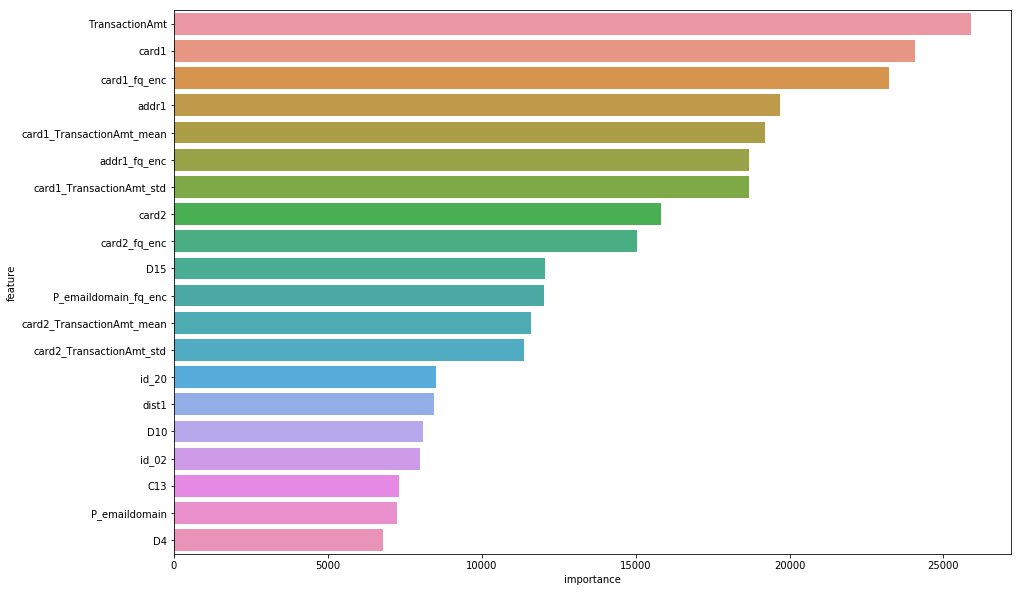

In [61]:
plt.figure(figsize=(15,10))
sns.barplot(x='importance', y='feature', data=feature_importance_df.head(20))

In [62]:
feature_importance_df

,feature,importance
0,TransactionAmt,25897
1,card1,24075
2,card1_fq_enc,23246
3,addr1,19697
4,card1_TransactionAmt_mean,19202
5,addr1_fq_enc,18692
6,card1_TransactionAmt_std,18667
7,card2,15815
8,card2_fq_enc,15048
9,D15,12066


In [68]:
feature_importance_df[feature_importance_df['feature'] == 'V313']

,feature,importance
44,V313,3208


In [69]:
feature_importance_df[feature_importance_df['feature'] == 'V314']

,feature,importance
74,V314,1649


In [70]:
feature_importance_df[feature_importance_df['feature'] == 'V315']

,feature,importance
68,V315,2113
